### Introduction
#### In this project we will use the geolospatial information of Los Angeles. The idea is to use the data to make suggestions regarding which districs are more suitable for opening a new restaurant. We will identify which districts have less restaurants than the rest, cluster them and make an appropriate suggestion. The fourquare database will be used to retrieve information for all the neighborhoods in our dataset. This step will be crucial when deciding to commence such an expensive procedure, like starting a new business. The same approach could be used to identify regions that are more suitable for opening new cafes. Of cource this is a simlified scenario. To address the question at each core, we should also take into account other factors, such as the average income in each neighborhood, the criminality levels, the average age of the citizens etc.. Obtaining this information for this project would be very hard to achieve, so we will restrict our analysis on the data we can retrieve from foursquare.

### The dataset
#### The data for this study have been retrieved from: https://usc.data.socrata.com/dataset/Los-Angeles-Neighborhood-Map/r8qd-yxsr. 
#### Let's first explore our data and plot a map of Los Angeles, highlighting with blue dots the neighborhoods of our dataset. 

In [160]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [161]:
with open('/home/christos/Downloads/LosAngelesNeighborhoodMap.geojson') as json_data:
    la_data = json.load(json_data)

In [162]:
neighborhoods_data = la_data['features']

In [163]:
column_names = ['City', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

for data in neighborhoods_data:
    neighborhood_name = data['properties']['name']
    neighborhood_lon = data['properties']['latitude']
    neighborhood_lat = data['properties']['longitude']
    
    neighborhoods = neighborhoods.append({'City': 'L.A.',
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [164]:
neighborhoods.sort_values('Neighborhood').head()

,City,Neighborhood,Latitude,Longitude
0,L.A.,Acton,34.497355239240846,-118.16981019229348
1,L.A.,Adams-Normandie,34.031461499124156,-118.30020800000011
2,L.A.,Agoura Hills,34.146736499122795,-118.75988450000015
3,L.A.,Agua Dulce,34.504926999796837,-118.3171036690717
4,L.A.,Alhambra,34.085538999123571,-118.13651200000021


In [165]:
address = 'Los Angeles'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of L.A are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of L.A are 34.0536909, -118.2427666.


In [166]:
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.9,
        parse_html=False).add_to(map_la)  
    
map_la

### Methodology
#### We are going to explore our data in order to reveal neighborhoods that are good targets for opening a new restaurant. We will identify which neighborhood have the least restaurants and make suggestions based on this observation. First, we can using basic plotting strategies, such as barplots, to compare the total number of restaurants in each neighborhoods, taking into account neighborhhods that have at least one restaurant. Next we will repeat the analysis taking into account all the available neighborhhods.

#### Since we are interested in the total number number of restaurants in each neighborhood and not on the type of the restaurant, we will have to modify the data reveived from foursquare. Foursquare originally returns the number of restaurants in each neighborhood, base on the type of the restaurant, i.e. Italian, Greek, Mexican etc. We will have to group our dataset based on the neighborhood name and estimate how many restaurants there are in total. This will also give us neighborhoods that do not have any restaurants (adding new information to the previous barplot).

#### Finally we are going to use the k-means clustering approach to make clusters of neighborhoods based on the venue information we have. Notice that we added a new venue that sums all the restaurants. You will notice that the map is not cleasr to make a proper decision. For this reason we are using a barplot to identify which labels correspond to neighborhoods with few or no restaurants. We can then suggest the appropriate neighborhoods based  on this observation.

### Analysis and results

In [167]:
#time to use fousquare
CLIENT_ID = 'W3ZU1DV2Y5S1IAA1YLB4IZNNXCQXC4J4GTF1ON4DIVXUNJIV' # your Foursquare ID
CLIENT_SECRET = 'FZB1RRL11JRXWRDHDBHZHSNSXQU4QPDKLFZ5LB4QFZUJII20' # your Foursquare Secret
VERSION = '20180605' # Foursquare API versionb

In [168]:
#explore neighborhoods in Toronto


def getNearbyVenues(names, latitudes, longitudes,LIMIT=100, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [169]:
la_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [170]:
##keep only restaurants
la_venues_forfood=la_venues[la_venues['Venue Category'].str.contains("Restaurant")].reset_index(drop=True)

In [153]:
#take total number of restaurants in each neighborhood
#doing this we ignore neighborhoods with no restaurants


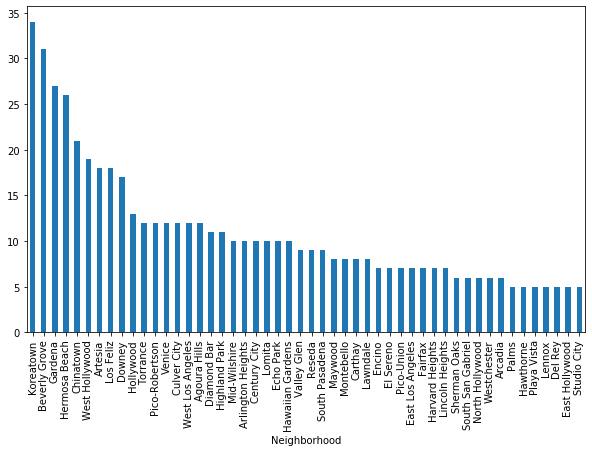

In [171]:
#plot the top 50 neighborhoods with the most restaurants

la_venues_forfood.groupby('Neighborhood').count()['Venue Category'].sort_values(ascending=False).head(50).plot(kind='bar', figsize=(10, 6))

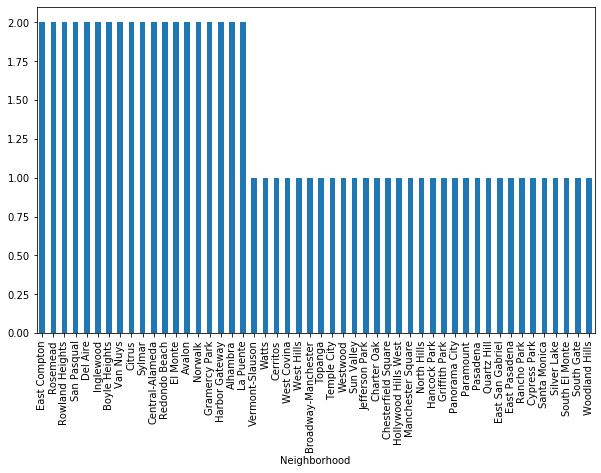

In [172]:
#plot the bottom 50 neighborhoods with the least restaurants

la_venues_forfood.groupby('Neighborhood').count()['Venue Category'].sort_values(ascending=False).tail(50).plot(kind='bar', figsize=(10, 6))

### From the plots above neighborhoods with no restaurants at all are missing. Lets try to include them in our analysis. 

In [173]:
# one hot encoding
la_hot = pd.get_dummies(la_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
la_hot['NeighborhoodName'] = la_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [la_hot.columns[-1]] + list(la_hot.columns[:-1])
la_hot = la_hot[fixed_columns]


In [174]:
#la_hot.iloc[353:429,:][la_hot.columns[la_hot.columns.str.contains("Restaurant")]].sum(axis=1).sum()

In [175]:
la_hotforfood=la_hot[la_hot.columns[la_hot.columns.str.contains("Restaurant")]]
la_hotforfood['NeighborhoodName']=la_hot['NeighborhoodName']
fixed_columns2 = [la_hotforfood.columns[-1]] + list(la_hotforfood.columns[:-1])
la_hotforfood = la_hotforfood[fixed_columns2]

/home/christos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [176]:
la_hotforfood['TotalRestaurants']=la_hotforfood[la_hotforfood.columns[la_hotforfood.columns.str.contains("Restaurant")]].sum(axis=1)

In [177]:
la_hotforfoodTotal=la_hotforfood.groupby('NeighborhoodName').sum()[['TotalRestaurants']]

In [178]:
la_hotforfoodTotal.index.name = None
la_hotforfoodTotal['NeighborhoodName']=la_hotforfoodTotal.index.tolist()

In [179]:
la_hotforfoodTotal.head(10)

,TotalRestaurants,NeighborhoodName
Acton,0,Acton
Adams-Normandie,3,Adams-Normandie
Agoura Hills,12,Agoura Hills
Agua Dulce,0,Agua Dulce
Alhambra,2,Alhambra
Alondra Park,0,Alondra Park
Altadena,0,Altadena
Arcadia,6,Arcadia
Arleta,0,Arleta
Arlington Heights,10,Arlington Heights


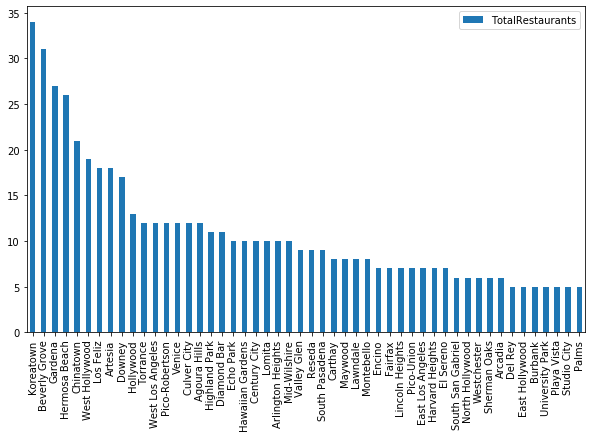

In [180]:
#repeat the barplot analysis including neighborhoods that do not have any restaurants

la_hotforfoodTotal.sort_values(by='TotalRestaurants',ascending=False).head(50).plot(kind='bar',figsize=(10, 6))

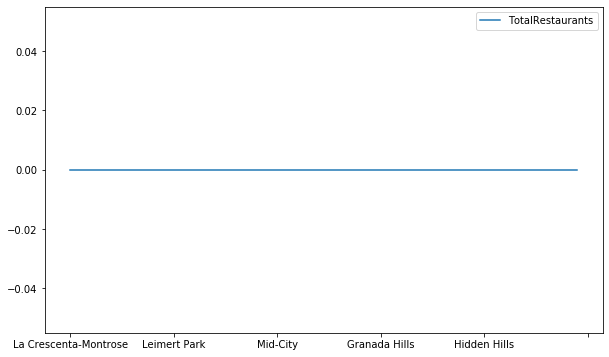

In [181]:
la_hotforfoodTotal.sort_values(by='TotalRestaurants',ascending=False).tail(50).plot(kind='line',figsize=(10, 6))

### We see that there are many ares with no restaurants at all. Lets try to cluster the neighborhoods.

In [182]:
#keep no-restaurant venues in a separate dataframe
la_hotnofood=la_hot[la_hot.columns[la_hot.columns.str.contains("Restaurant")==False]]

In [183]:
# now we have two dataframes, one that has information only for the restaurants, 
#and one that have information for the rest venues

print(la_hotnofood.shape,la_hotforfood.shape)

(2958, 264) (2958, 58)


In [184]:
#let's merge the two datasets
# now we removed the differents types of restaurants and kept only the total number of restaurants in each
#neighborhhod
la_hotTotal=pd.concat([la_hotforfood[['TotalRestaurants']],la_hotnofood],axis=1, sort=False)

In [185]:
la_grouped = la_hotTotal.groupby('NeighborhoodName').mean()


In [186]:
#perform clustering

# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.shape

(239,)

In [195]:
neighborhoods.index=neighborhoods['Neighborhood']
indexx=la_grouped.index.tolist()
neighborhoods_new=neighborhoods.loc[indexx]

neighborhoods_new.insert(0, 'Cluster Labels', kmeans.labels_)

In [196]:
neighborhoods_new.head()

,Cluster Labels,City,Neighborhood,Latitude,Longitude
Neighborhood,,,,,
Acton,5,L.A.,Acton,34.497355239240846,-118.16981019229348
Adams-Normandie,0,L.A.,Adams-Normandie,34.031461499124156,-118.30020800000011
Agoura Hills,0,L.A.,Agoura Hills,34.146736499122795,-118.75988450000015
Agua Dulce,8,L.A.,Agua Dulce,34.504926999796837,-118.3171036690717
Alhambra,8,L.A.,Alhambra,34.085538999123571,-118.13651200000021


In [197]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_new['Latitude'], neighborhoods_new['Longitude'], neighborhoods_new['Neighborhood'], neighborhoods_new['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### We can clearly say that we cannot make a suggestion based on this map. Let's try again keeping only information regarding the restaurant number in each neighborhood.

In [198]:
la_grouped_resta=la_grouped[['TotalRestaurants']]

In [199]:
la_grouped_resta.head()

,TotalRestaurants
NeighborhoodName,
Acton,0.000000
Adams-Normandie,0.333333
Agoura Hills,0.428571
Agua Dulce,0.000000
Alhambra,0.153846


In [200]:
#perform clustering

# set number of clusters
kclusters = 10

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(la_grouped_resta)

# check cluster labels generated for each row in the dataframe
kmeans.labels_.shape

(239,)

In [201]:
indexx=la_grouped.index.tolist()
neighborhoods_resta=neighborhoods.loc[indexx]

neighborhoods_resta.insert(0, 'Cluster Labels', kmeans.labels_)

In [202]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhoods_resta['Latitude'], neighborhoods_resta['Longitude'], neighborhoods_resta['Neighborhood'], neighborhoods_resta['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Slightly better. We have better cluster now, but still not clear. Let's try to make a barplot to see wch clusters correspond to neighborhoods with few restaurants.

In [203]:
la_grouped_resta['Neighborhood']=la_grouped_resta.index.values.tolist()
la_grouped_resta2=la_grouped_resta.reset_index()
la_grouped_resta2.drop('NeighborhoodName',axis=1, inplace=True)
la_grouped_resta2.drop('Neighborhood',axis=1, inplace=True)

/home/christos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [204]:
neighborhoods_resta.index.name=None

In [205]:
neighborhoods_resta2=neighborhoods_resta.reset_index()

In [206]:
neighborhoods_resta2.drop('index', axis=1, inplace=True)

In [207]:
neighborhoods_resta2.head()

,Cluster Labels,City,Neighborhood,Latitude,Longitude
0,0,L.A.,Acton,34.497355239240846,-118.16981019229348
1,1,L.A.,Adams-Normandie,34.031461499124156,-118.30020800000011
2,5,L.A.,Agoura Hills,34.146736499122795,-118.75988450000015
3,0,L.A.,Agua Dulce,34.504926999796837,-118.3171036690717
4,6,L.A.,Alhambra,34.085538999123571,-118.13651200000021


In [208]:
la_grouped_resta2.head()

,TotalRestaurants
0,0.000000
1,0.333333
2,0.428571
3,0.000000
4,0.153846


In [209]:
final_dataset=pd.concat([la_grouped_resta2,neighborhoods_resta2],axis=1, sort=False)

In [211]:
final_dataset.head()

,TotalRestaurants,Cluster Labels,City,Neighborhood,Latitude,Longitude
0,0.000000,0,L.A.,Acton,34.497355239240846,-118.16981019229348
1,0.333333,1,L.A.,Adams-Normandie,34.031461499124156,-118.30020800000011
2,0.428571,5,L.A.,Agoura Hills,34.146736499122795,-118.75988450000015
3,0.000000,0,L.A.,Agua Dulce,34.504926999796837,-118.3171036690717
4,0.153846,6,L.A.,Alhambra,34.085538999123571,-118.13651200000021


In [212]:
import matplotlib.pyplot as plt

Text(0, 0.5, '% of Restaurants in neighborhood')

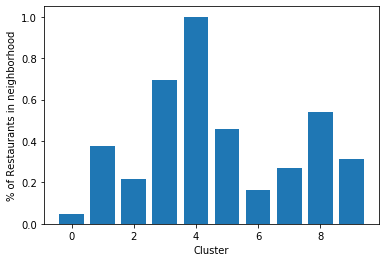

In [213]:
plt.bar(x=final_dataset['Cluster Labels'],height=final_dataset['TotalRestaurants'])
plt.xlabel('Cluster')
plt.ylabel('% of Restaurants in neighborhood')

### We can say that neighborhoods with cluster labels 0 and 6 do not have may restaurants. Let's view these neighborhoods.

In [214]:
final_dataset.loc[(final_dataset['Cluster Labels']==0) | (final_dataset['Cluster Labels']==6) ,:].head()

,TotalRestaurants,Cluster Labels,City,Neighborhood,Latitude,Longitude
0,0.000000,0,L.A.,Acton,34.497355239240846,-118.16981019229348
3,0.000000,0,L.A.,Agua Dulce,34.504926999796837,-118.3171036690717
4,0.153846,6,L.A.,Alhambra,34.085538999123571,-118.13651200000021
5,0.000000,0,L.A.,Alondra Park,33.889617004889644,-118.33515598608159
6,0.000000,0,L.A.,Altadena,34.193870502232173,-118.13623898201556


### Discussion

#### Using the k-means clustering approach we identied neighborhoods that cluster together, based only on the number of restaurants in each neighborhood. We found that neighborhoods labeled with 0 and 6 do not have many restaurants and subsequently would be the best options to start a new restaurant.

### Conclusion
#### Trying to make suggestion about carrer opportunities is not easy. Here, we combined basic plotting startegies with clustering methods to obtain a basic intuition about which neighborhood in L.A is appropriate for opening a new restaurant. We based our analysis only on the number of restaurants in each area. To complete this analysis many more parameters must be taken into account. This would be just the first step trying to answer a real-world reseach question.